In [1]:
import sys
sys.path.append('../')

In [2]:
from utils.data import CIFAR10_dataset
from utils.basic import (
    show_random_images,
    get_device,
    set_seed,
    is_cuda,
    show_model_summary,
    show_img_grid,
    show_random_images_for_each_class
)
from utils.model import Net
from utils.training import train
from utils.testing import test

In [3]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import numpy as np
import torchvision

## albumenation

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
       shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=45, interpolation=1, 
        border_mode=4, p=0.5
    ),
    A.CoarseDropout(
        max_holes=8, max_height=8, 
        max_width=8, p=0.5
    ),
    A.RandomBrightnessContrast(p=0.2),
    A.ToGray(p=0.1),
    A.Normalize(
        mean=(0.491, 0.482, 0.447), 
        std=(0.247, 0.243, 0.262),
        always_apply=True
    ),
    ToTensorV2(),
])

### Device

In [8]:
set_seed()
cuda = is_cuda()
device = get_device()

[INFO] seed set 1
[INFO] Cuda Avaliable :  True
[INFO] device :  cuda


## Data Loader

In [9]:
train_loader = CIFAR10_dataset(
    train=True, cuda=cuda
).get_loader()
test_loader = CIFAR10_dataset(
    train=False, cuda=cuda
).get_loader()

Files already downloaded and verified

        [INFO] train dataset of size 50000 loaded...
        
Files already downloaded and verified

        [INFO] test dataset of size 10000 loaded...
        


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


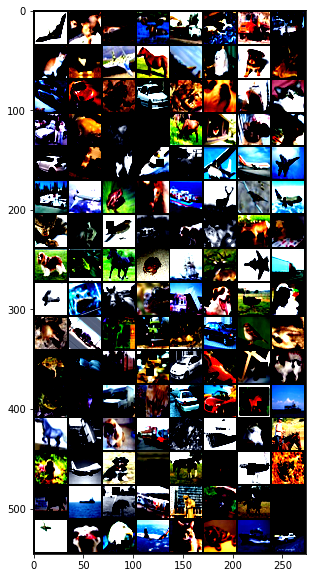

In [10]:
show_random_images(train_loader)

In [11]:
# writer = SummaryWriter('./runs/cifar10_2')

In [12]:
sample_batch = next(iter(train_loader))[0]
sample_img_grid = torchvision.utils.make_grid(sample_batch)
sample_batch.shape[1:]

torch.Size([3, 32, 32])

In [13]:
# writer.add_image('normalized_train_images', sample_img_grid)

In [14]:
# writer.close()

## Load Model

In [15]:
results = {}
models = {}

In [16]:
experiments= {
    "first_exp": {
        'BN': True, 'dropout_value': 0.2,
        'GN': False, 'LN': False, 'L1': False, 'L2': False
    },
}
EPOCHS = 500

In [19]:
net = Net(
    dropout_value=0.2, BN=True
).to(device)
show_model_summary(net, input_size=sample_batch.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
           Dropout-3           [-1, 32, 32, 32]               0
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
           Dropout-7           [-1, 64, 32, 32]               0
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]          36,864
             ReLU-10           [-1, 64, 32, 32]               0
          Dropout-11           [-1, 64, 32, 32]               0
      BatchNorm2d-12           [-1, 64, 32, 32]             128
           Conv2d-13           [-1, 32, 17, 17]           2,080
             ReLU-14           [-1, 32,

In [20]:
for exp_name, exp in experiments.items():
    print("Experiment : ", exp_name)
    results[exp_name] = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'epoch': [],
    }

    net = Net(
        dropout_value=exp['dropout_value'], BN=exp['BN'], GN=exp['GN'], LN=exp['LN']
    ).to(device)
    show_model_summary(net, input_size=sample_batch.shape[1:])
    # writer.add_graph(net, sample_batch.to(device))
    # wandb.watch(net, log_freq=100)

    weight_decay = 1e-5 if exp['L2'] else 0
    optimizer = optim.SGD(
        net.parameters(), 
        lr=0.015, momentum=0.9, 
        weight_decay=weight_decay
    )
    lr_scheduler = ReduceLROnPlateau(
        optimizer, mode='min', factor=0.2, 
        patience=3, min_lr=0.0001, verbose=True
    )

    for epoch in range(0, EPOCHS + 1):
        print(f"[EPOCH {epoch} / {EPOCHS}] -- ")
        train_loss_batch, train_acc_batch = train(
            net, device, 
            train_loader, 
            optimizer, 
            lr_scheduler,
            L1=exp['L1']
        )
        
        train_acc = np.mean(train_acc_batch)
        train_loss = np.mean(train_loss_batch)

        test_loss, test_acc = test(
            net, device, 
            test_loader,
            lr_scheduler
        )
        
        for metric in ['train_loss', 'train_acc', 'test_loss', 'test_acc', 'epoch']:
            results[exp_name][metric].append(eval(metric))
    
    models[exp_name] = net


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: askmuhsin (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


  0%|          | 0/391 [00:00<?, ?it/s]

Experiment :  first_exp
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
           Dropout-3           [-1, 32, 32, 32]               0
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
           Dropout-7           [-1, 64, 32, 32]               0
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]          36,864
             ReLU-10           [-1, 64, 32, 32]               0
          Dropout-11           [-1, 64, 32, 32]               0
      BatchNorm2d-12           [-1, 64, 32, 32]             128
           Conv2d-13           [-1, 32, 17, 17]           2,080
             Re

Loss=1.3323101997375488 Batch_id=390 Accuracy=36.97: 100%|██████████| 391/391 [00:09<00:00, 39.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.3474, Accuracy: 5111/10000 (51.11%)

[EPOCH 1 / 500] -- 


Loss=1.3395029306411743 Batch_id=390 Accuracy=49.59: 100%|██████████| 391/391 [00:15<00:00, 24.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.1453, Accuracy: 5814/10000 (58.14%)

[EPOCH 2 / 500] -- 


Loss=1.1850202083587646 Batch_id=390 Accuracy=54.71: 100%|██████████| 391/391 [00:10<00:00, 38.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0423, Accuracy: 6245/10000 (62.45%)

[EPOCH 3 / 500] -- 


Loss=1.1960726976394653 Batch_id=390 Accuracy=58.56: 100%|██████████| 391/391 [00:09<00:00, 41.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9479, Accuracy: 6568/10000 (65.68%)

[EPOCH 4 / 500] -- 


Loss=0.8458970785140991 Batch_id=390 Accuracy=60.97: 100%|██████████| 391/391 [00:09<00:00, 40.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8897, Accuracy: 6800/10000 (68.00%)

[EPOCH 5 / 500] -- 


Loss=1.336883544921875 Batch_id=390 Accuracy=63.09: 100%|██████████| 391/391 [00:11<00:00, 33.47it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8388, Accuracy: 7047/10000 (70.47%)

[EPOCH 6 / 500] -- 


Loss=0.985329806804657 Batch_id=390 Accuracy=64.63: 100%|██████████| 391/391 [00:10<00:00, 36.89it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8074, Accuracy: 7150/10000 (71.50%)

[EPOCH 7 / 500] -- 


Loss=0.979566216468811 Batch_id=390 Accuracy=66.04: 100%|██████████| 391/391 [00:09<00:00, 39.32it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7704, Accuracy: 7271/10000 (72.71%)

[EPOCH 8 / 500] -- 


Loss=0.9942011833190918 Batch_id=390 Accuracy=66.96: 100%|██████████| 391/391 [00:11<00:00, 34.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7276, Accuracy: 7426/10000 (74.26%)

[EPOCH 9 / 500] -- 


Loss=0.7984920740127563 Batch_id=390 Accuracy=67.92: 100%|██████████| 391/391 [00:10<00:00, 38.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7110, Accuracy: 7489/10000 (74.89%)

[EPOCH 10 / 500] -- 


Loss=0.9223629236221313 Batch_id=390 Accuracy=68.93: 100%|██████████| 391/391 [00:11<00:00, 34.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6877, Accuracy: 7594/10000 (75.94%)

[EPOCH 11 / 500] -- 


Loss=0.8129749298095703 Batch_id=390 Accuracy=69.78: 100%|██████████| 391/391 [00:10<00:00, 38.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6862, Accuracy: 7595/10000 (75.95%)

[EPOCH 12 / 500] -- 


Loss=0.6988564729690552 Batch_id=390 Accuracy=70.38: 100%|██████████| 391/391 [00:14<00:00, 26.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6664, Accuracy: 7659/10000 (76.59%)

[EPOCH 13 / 500] -- 


Loss=1.0190911293029785 Batch_id=390 Accuracy=71.09: 100%|██████████| 391/391 [00:10<00:00, 38.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6556, Accuracy: 7679/10000 (76.79%)

[EPOCH 14 / 500] -- 


Loss=0.8204767107963562 Batch_id=390 Accuracy=71.59: 100%|██████████| 391/391 [00:10<00:00, 37.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6227, Accuracy: 7865/10000 (78.65%)

[EPOCH 15 / 500] -- 


Loss=0.7832554578781128 Batch_id=390 Accuracy=72.02: 100%|██████████| 391/391 [00:09<00:00, 40.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5944, Accuracy: 7951/10000 (79.51%)

[EPOCH 16 / 500] -- 


Loss=0.926749587059021 Batch_id=390 Accuracy=72.72: 100%|██████████| 391/391 [00:13<00:00, 29.17it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6035, Accuracy: 7913/10000 (79.13%)

[EPOCH 17 / 500] -- 


Loss=0.8714362382888794 Batch_id=390 Accuracy=73.07: 100%|██████████| 391/391 [00:10<00:00, 36.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5917, Accuracy: 7962/10000 (79.62%)

[EPOCH 18 / 500] -- 


Loss=0.7912548184394836 Batch_id=390 Accuracy=73.28: 100%|██████████| 391/391 [00:10<00:00, 38.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5846, Accuracy: 7989/10000 (79.89%)

[EPOCH 19 / 500] -- 


Loss=0.8119962811470032 Batch_id=390 Accuracy=73.47: 100%|██████████| 391/391 [00:11<00:00, 34.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5949, Accuracy: 7942/10000 (79.42%)

[EPOCH 20 / 500] -- 


Loss=0.5307092666625977 Batch_id=390 Accuracy=74.14: 100%|██████████| 391/391 [00:10<00:00, 38.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5777, Accuracy: 8005/10000 (80.05%)

[EPOCH 21 / 500] -- 


Loss=0.7694862484931946 Batch_id=390 Accuracy=74.38: 100%|██████████| 391/391 [00:10<00:00, 36.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5597, Accuracy: 8063/10000 (80.63%)

[EPOCH 22 / 500] -- 


Loss=0.8409790992736816 Batch_id=390 Accuracy=74.61: 100%|██████████| 391/391 [00:10<00:00, 35.94it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5754, Accuracy: 8018/10000 (80.18%)

[EPOCH 23 / 500] -- 


Loss=0.7617672085762024 Batch_id=390 Accuracy=75.16: 100%|██████████| 391/391 [00:10<00:00, 35.68it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5518, Accuracy: 8106/10000 (81.06%)

[EPOCH 24 / 500] -- 


Loss=0.9656778573989868 Batch_id=390 Accuracy=75.01: 100%|██████████| 391/391 [00:12<00:00, 32.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5356, Accuracy: 8185/10000 (81.85%)

[EPOCH 25 / 500] -- 


Loss=0.7409988045692444 Batch_id=390 Accuracy=75.35: 100%|██████████| 391/391 [00:11<00:00, 33.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5608, Accuracy: 8093/10000 (80.93%)

[EPOCH 26 / 500] -- 


Loss=0.7079620361328125 Batch_id=390 Accuracy=75.66: 100%|██████████| 391/391 [00:13<00:00, 29.78it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5301, Accuracy: 8179/10000 (81.79%)

[EPOCH 27 / 500] -- 


Loss=0.7607666850090027 Batch_id=390 Accuracy=75.71: 100%|██████████| 391/391 [00:10<00:00, 38.79it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5487, Accuracy: 8166/10000 (81.66%)

[EPOCH 28 / 500] -- 


Loss=0.5682892203330994 Batch_id=390 Accuracy=75.97: 100%|██████████| 391/391 [00:10<00:00, 35.67it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5071, Accuracy: 8260/10000 (82.60%)

[EPOCH 29 / 500] -- 


Loss=0.6973447799682617 Batch_id=390 Accuracy=76.14: 100%|██████████| 391/391 [00:09<00:00, 39.84it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5149, Accuracy: 8244/10000 (82.44%)

[EPOCH 30 / 500] -- 


Loss=0.6295843124389648 Batch_id=390 Accuracy=76.35: 100%|██████████| 391/391 [00:10<00:00, 35.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5130, Accuracy: 8249/10000 (82.49%)

[EPOCH 31 / 500] -- 


Loss=0.6708377003669739 Batch_id=390 Accuracy=76.54: 100%|██████████| 391/391 [00:11<00:00, 33.31it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5041, Accuracy: 8275/10000 (82.75%)

[EPOCH 32 / 500] -- 


Loss=0.5666126012802124 Batch_id=390 Accuracy=76.90: 100%|██████████| 391/391 [00:09<00:00, 39.80it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5079, Accuracy: 8277/10000 (82.77%)

[EPOCH 33 / 500] -- 


Loss=0.688528835773468 Batch_id=390 Accuracy=76.90: 100%|██████████| 391/391 [00:09<00:00, 39.52it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5185, Accuracy: 8228/10000 (82.28%)

[EPOCH 34 / 500] -- 


Loss=0.8061864972114563 Batch_id=390 Accuracy=77.01: 100%|██████████| 391/391 [00:09<00:00, 39.47it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4974, Accuracy: 8291/10000 (82.91%)

[EPOCH 35 / 500] -- 


Loss=0.643330991268158 Batch_id=390 Accuracy=77.47: 100%|██████████| 391/391 [00:09<00:00, 40.89it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4950, Accuracy: 8304/10000 (83.04%)

[EPOCH 36 / 500] -- 


Loss=0.8253556489944458 Batch_id=390 Accuracy=77.29: 100%|██████████| 391/391 [00:10<00:00, 39.05it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4797, Accuracy: 8359/10000 (83.59%)

[EPOCH 37 / 500] -- 


Loss=0.5111714005470276 Batch_id=390 Accuracy=77.49: 100%|██████████| 391/391 [00:10<00:00, 38.30it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4910, Accuracy: 8317/10000 (83.17%)

[EPOCH 38 / 500] -- 


Loss=0.8684131503105164 Batch_id=390 Accuracy=77.72: 100%|██████████| 391/391 [00:10<00:00, 36.68it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4978, Accuracy: 8302/10000 (83.02%)

[EPOCH 39 / 500] -- 


Loss=0.6628566384315491 Batch_id=390 Accuracy=77.43: 100%|██████████| 391/391 [00:10<00:00, 38.33it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4820, Accuracy: 8366/10000 (83.66%)

[EPOCH 40 / 500] -- 


Loss=0.7396952509880066 Batch_id=390 Accuracy=77.73: 100%|██████████| 391/391 [00:10<00:00, 35.77it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    41: reducing learning rate of group 0 to 3.0000e-03.

Test set: Average loss: 0.4996, Accuracy: 8306/10000 (83.06%)

[EPOCH 41 / 500] -- 


Loss=0.4796312749385834 Batch_id=390 Accuracy=79.01: 100%|██████████| 391/391 [00:10<00:00, 38.53it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4446, Accuracy: 8493/10000 (84.93%)

[EPOCH 42 / 500] -- 


Loss=0.5841337442398071 Batch_id=390 Accuracy=79.55: 100%|██████████| 391/391 [00:11<00:00, 34.50it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4421, Accuracy: 8503/10000 (85.03%)

[EPOCH 43 / 500] -- 


Loss=0.6707457304000854 Batch_id=390 Accuracy=80.07: 100%|██████████| 391/391 [00:10<00:00, 35.66it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4422, Accuracy: 8486/10000 (84.86%)

[EPOCH 44 / 500] -- 


Loss=0.6058759689331055 Batch_id=390 Accuracy=79.77: 100%|██████████| 391/391 [00:09<00:00, 39.24it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4382, Accuracy: 8509/10000 (85.09%)

[EPOCH 45 / 500] -- 


Loss=0.6127276420593262 Batch_id=390 Accuracy=79.97: 100%|██████████| 391/391 [00:09<00:00, 39.37it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4381, Accuracy: 8507/10000 (85.07%)

[EPOCH 46 / 500] -- 


Loss=0.6135624647140503 Batch_id=390 Accuracy=80.03: 100%|██████████| 391/391 [00:09<00:00, 40.13it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4402, Accuracy: 8493/10000 (84.93%)

[EPOCH 47 / 500] -- 


Loss=0.6020029783248901 Batch_id=390 Accuracy=80.11: 100%|██████████| 391/391 [00:13<00:00, 29.45it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4320, Accuracy: 8519/10000 (85.19%)

[EPOCH 48 / 500] -- 


Loss=0.42090821266174316 Batch_id=390 Accuracy=79.92: 100%|██████████| 391/391 [00:10<00:00, 36.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4281, Accuracy: 8541/10000 (85.41%)

[EPOCH 49 / 500] -- 


Loss=0.6142758727073669 Batch_id=390 Accuracy=80.18: 100%|██████████| 391/391 [00:11<00:00, 33.66it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4377, Accuracy: 8518/10000 (85.18%)

[EPOCH 50 / 500] -- 


Loss=0.6704979538917542 Batch_id=390 Accuracy=80.03: 100%|██████████| 391/391 [00:09<00:00, 41.12it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4292, Accuracy: 8522/10000 (85.22%)

[EPOCH 51 / 500] -- 


Loss=0.5741110444068909 Batch_id=390 Accuracy=80.49: 100%|██████████| 391/391 [00:10<00:00, 37.97it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4296, Accuracy: 8520/10000 (85.20%)

[EPOCH 52 / 500] -- 


Loss=0.6808024644851685 Batch_id=390 Accuracy=80.27: 100%|██████████| 391/391 [00:11<00:00, 33.47it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4264, Accuracy: 8533/10000 (85.33%)

[EPOCH 53 / 500] -- 


Loss=0.5171766877174377 Batch_id=390 Accuracy=80.28: 100%|██████████| 391/391 [00:10<00:00, 38.30it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4286, Accuracy: 8540/10000 (85.40%)

[EPOCH 54 / 500] -- 


Loss=0.4915199279785156 Batch_id=390 Accuracy=80.55: 100%|██████████| 391/391 [00:10<00:00, 35.70it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4306, Accuracy: 8547/10000 (85.47%)

[EPOCH 55 / 500] -- 


Loss=0.4467635154724121 Batch_id=390 Accuracy=80.53: 100%|██████████| 391/391 [00:11<00:00, 33.54it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4317, Accuracy: 8555/10000 (85.55%)

[EPOCH 56 / 500] -- 


Loss=0.7397323846817017 Batch_id=390 Accuracy=80.22: 100%|██████████| 391/391 [00:10<00:00, 38.99it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4258, Accuracy: 8552/10000 (85.52%)

[EPOCH 57 / 500] -- 


Loss=0.5088905096054077 Batch_id=390 Accuracy=80.45: 100%|██████████| 391/391 [00:10<00:00, 38.00it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4263, Accuracy: 8542/10000 (85.42%)

[EPOCH 58 / 500] -- 


Loss=0.527154803276062 Batch_id=390 Accuracy=80.62: 100%|██████████| 391/391 [00:10<00:00, 36.00it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4249, Accuracy: 8564/10000 (85.64%)

[EPOCH 59 / 500] -- 


Loss=0.815516471862793 Batch_id=390 Accuracy=80.56: 100%|██████████| 391/391 [00:10<00:00, 38.46it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4243, Accuracy: 8562/10000 (85.62%)

[EPOCH 60 / 500] -- 


Loss=0.360407292842865 Batch_id=390 Accuracy=80.42: 100%|██████████| 391/391 [00:10<00:00, 35.72it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4211, Accuracy: 8555/10000 (85.55%)

[EPOCH 61 / 500] -- 


Loss=0.5758739709854126 Batch_id=390 Accuracy=80.51: 100%|██████████| 391/391 [00:09<00:00, 40.10it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4271, Accuracy: 8540/10000 (85.40%)

[EPOCH 62 / 500] -- 


Loss=0.46974191069602966 Batch_id=390 Accuracy=80.57: 100%|██████████| 391/391 [00:11<00:00, 35.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4237, Accuracy: 8569/10000 (85.69%)

[EPOCH 63 / 500] -- 


Loss=0.46464458107948303 Batch_id=390 Accuracy=80.56: 100%|██████████| 391/391 [00:10<00:00, 38.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4193, Accuracy: 8579/10000 (85.79%)

[EPOCH 64 / 500] -- 


Loss=0.5271225571632385 Batch_id=390 Accuracy=80.54: 100%|██████████| 391/391 [00:12<00:00, 31.95it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4214, Accuracy: 8561/10000 (85.61%)

[EPOCH 65 / 500] -- 


Loss=0.4553033709526062 Batch_id=390 Accuracy=80.81: 100%|██████████| 391/391 [00:10<00:00, 36.29it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4183, Accuracy: 8588/10000 (85.88%)

[EPOCH 66 / 500] -- 


Loss=0.5693133473396301 Batch_id=390 Accuracy=80.59: 100%|██████████| 391/391 [00:09<00:00, 39.48it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4167, Accuracy: 8594/10000 (85.94%)

[EPOCH 67 / 500] -- 


Loss=0.8352636098861694 Batch_id=390 Accuracy=80.78: 100%|██████████| 391/391 [00:10<00:00, 37.91it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4175, Accuracy: 8557/10000 (85.57%)

[EPOCH 68 / 500] -- 


Loss=0.6779524683952332 Batch_id=390 Accuracy=80.66: 100%|██████████| 391/391 [00:10<00:00, 35.83it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4200, Accuracy: 8575/10000 (85.75%)

[EPOCH 69 / 500] -- 


Loss=0.6774669885635376 Batch_id=390 Accuracy=80.73: 100%|██████████| 391/391 [00:09<00:00, 39.92it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4215, Accuracy: 8569/10000 (85.69%)

[EPOCH 70 / 500] -- 


Loss=0.4067462980747223 Batch_id=390 Accuracy=80.86: 100%|██████████| 391/391 [00:11<00:00, 35.28it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    71: reducing learning rate of group 0 to 6.0000e-04.

Test set: Average loss: 0.4200, Accuracy: 8580/10000 (85.80%)

[EPOCH 71 / 500] -- 


Loss=0.5240951776504517 Batch_id=390 Accuracy=81.22: 100%|██████████| 391/391 [00:13<00:00, 28.48it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4122, Accuracy: 8625/10000 (86.25%)

[EPOCH 72 / 500] -- 


Loss=0.6895385980606079 Batch_id=390 Accuracy=81.15: 100%|██████████| 391/391 [00:10<00:00, 37.44it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4137, Accuracy: 8624/10000 (86.24%)

[EPOCH 73 / 500] -- 


Loss=0.5064722299575806 Batch_id=390 Accuracy=81.31: 100%|██████████| 391/391 [00:11<00:00, 35.45it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4119, Accuracy: 8614/10000 (86.14%)

[EPOCH 74 / 500] -- 


Loss=0.5398756861686707 Batch_id=390 Accuracy=81.16: 100%|██████████| 391/391 [00:09<00:00, 39.12it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4120, Accuracy: 8605/10000 (86.05%)

[EPOCH 75 / 500] -- 


Loss=0.713097095489502 Batch_id=390 Accuracy=81.17: 100%|██████████| 391/391 [00:12<00:00, 30.47it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4124, Accuracy: 8625/10000 (86.25%)

[EPOCH 76 / 500] -- 


Loss=0.4670758843421936 Batch_id=390 Accuracy=81.39: 100%|██████████| 391/391 [00:10<00:00, 37.08it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4152, Accuracy: 8605/10000 (86.05%)

[EPOCH 77 / 500] -- 


Loss=0.47154513001441956 Batch_id=390 Accuracy=81.33: 100%|██████████| 391/391 [00:10<00:00, 38.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4118, Accuracy: 8618/10000 (86.18%)

[EPOCH 78 / 500] -- 


Loss=0.41504621505737305 Batch_id=390 Accuracy=81.32: 100%|██████████| 391/391 [00:09<00:00, 40.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4126, Accuracy: 8615/10000 (86.15%)

[EPOCH 79 / 500] -- 


Loss=0.46800804138183594 Batch_id=390 Accuracy=81.21: 100%|██████████| 391/391 [00:10<00:00, 38.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4114, Accuracy: 8621/10000 (86.21%)

[EPOCH 80 / 500] -- 


Loss=0.6154489517211914 Batch_id=390 Accuracy=81.15: 100%|██████████| 391/391 [00:10<00:00, 37.85it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4108, Accuracy: 8618/10000 (86.18%)

[EPOCH 81 / 500] -- 


Loss=0.575916051864624 Batch_id=390 Accuracy=81.40: 100%|██████████| 391/391 [00:13<00:00, 28.77it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4127, Accuracy: 8606/10000 (86.06%)

[EPOCH 82 / 500] -- 


Loss=0.4281964898109436 Batch_id=390 Accuracy=81.44: 100%|██████████| 391/391 [00:10<00:00, 38.39it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4116, Accuracy: 8610/10000 (86.10%)

[EPOCH 83 / 500] -- 


Loss=0.5380051136016846 Batch_id=390 Accuracy=81.47: 100%|██████████| 391/391 [00:09<00:00, 39.23it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4113, Accuracy: 8602/10000 (86.02%)

[EPOCH 84 / 500] -- 


Loss=0.5060745477676392 Batch_id=390 Accuracy=81.26: 100%|██████████| 391/391 [00:10<00:00, 38.53it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4095, Accuracy: 8620/10000 (86.20%)

[EPOCH 85 / 500] -- 


Loss=0.7077541351318359 Batch_id=390 Accuracy=81.50: 100%|██████████| 391/391 [00:10<00:00, 37.54it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4102, Accuracy: 8611/10000 (86.11%)

[EPOCH 86 / 500] -- 


Loss=0.6379465460777283 Batch_id=390 Accuracy=81.18: 100%|██████████| 391/391 [00:10<00:00, 37.75it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4103, Accuracy: 8614/10000 (86.14%)

[EPOCH 87 / 500] -- 


Loss=0.4448533058166504 Batch_id=390 Accuracy=81.40: 100%|██████████| 391/391 [00:09<00:00, 39.46it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4109, Accuracy: 8608/10000 (86.08%)

[EPOCH 88 / 500] -- 


Loss=0.5690959095954895 Batch_id=390 Accuracy=81.56: 100%|██████████| 391/391 [00:14<00:00, 26.28it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    89: reducing learning rate of group 0 to 1.2000e-04.

Test set: Average loss: 0.4114, Accuracy: 8626/10000 (86.26%)

[EPOCH 89 / 500] -- 


Loss=0.2926557660102844 Batch_id=390 Accuracy=81.42: 100%|██████████| 391/391 [00:12<00:00, 31.64it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4092, Accuracy: 8629/10000 (86.29%)

[EPOCH 90 / 500] -- 


Loss=0.48048704862594604 Batch_id=390 Accuracy=81.38: 100%|██████████| 391/391 [00:13<00:00, 30.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4081, Accuracy: 8628/10000 (86.28%)

[EPOCH 91 / 500] -- 


Loss=0.484745591878891 Batch_id=390 Accuracy=81.49: 100%|██████████| 391/391 [00:09<00:00, 39.28it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4088, Accuracy: 8632/10000 (86.32%)

[EPOCH 92 / 500] -- 


Loss=0.4516909718513489 Batch_id=390 Accuracy=81.12: 100%|██████████| 391/391 [00:09<00:00, 39.54it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4100, Accuracy: 8615/10000 (86.15%)

[EPOCH 93 / 500] -- 


Loss=0.7807222604751587 Batch_id=390 Accuracy=81.58: 100%|██████████| 391/391 [00:10<00:00, 38.64it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4082, Accuracy: 8623/10000 (86.23%)

[EPOCH 94 / 500] -- 


Loss=0.9214555025100708 Batch_id=390 Accuracy=81.38: 100%|██████████| 391/391 [00:12<00:00, 30.92it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    95: reducing learning rate of group 0 to 1.0000e-04.

Test set: Average loss: 0.4100, Accuracy: 8617/10000 (86.17%)

[EPOCH 95 / 500] -- 


Loss=0.4256274700164795 Batch_id=390 Accuracy=81.70: 100%|██████████| 391/391 [00:12<00:00, 32.24it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4081, Accuracy: 8618/10000 (86.18%)

[EPOCH 96 / 500] -- 


Loss=0.601299524307251 Batch_id=390 Accuracy=81.28: 100%|██████████| 391/391 [00:09<00:00, 39.16it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4079, Accuracy: 8614/10000 (86.14%)

[EPOCH 97 / 500] -- 


Loss=0.5063514113426208 Batch_id=390 Accuracy=81.61: 100%|██████████| 391/391 [00:10<00:00, 37.77it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4098, Accuracy: 8623/10000 (86.23%)

[EPOCH 98 / 500] -- 


Loss=0.5980241894721985 Batch_id=390 Accuracy=81.33: 100%|██████████| 391/391 [00:10<00:00, 38.36it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4096, Accuracy: 8635/10000 (86.35%)

[EPOCH 99 / 500] -- 


Loss=0.589485228061676 Batch_id=390 Accuracy=81.71: 100%|██████████| 391/391 [00:10<00:00, 37.89it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4087, Accuracy: 8620/10000 (86.20%)

[EPOCH 100 / 500] -- 


Loss=0.41835957765579224 Batch_id=390 Accuracy=81.51: 100%|██████████| 391/391 [00:14<00:00, 27.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4110, Accuracy: 8617/10000 (86.17%)

[EPOCH 101 / 500] -- 


Loss=0.5843406319618225 Batch_id=390 Accuracy=81.50: 100%|██████████| 391/391 [00:10<00:00, 37.09it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4082, Accuracy: 8620/10000 (86.20%)

[EPOCH 102 / 500] -- 


Loss=0.4794067442417145 Batch_id=390 Accuracy=81.19: 100%|██████████| 391/391 [00:09<00:00, 39.46it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4094, Accuracy: 8626/10000 (86.26%)

[EPOCH 103 / 500] -- 


Loss=0.5143781900405884 Batch_id=390 Accuracy=81.50: 100%|██████████| 391/391 [00:10<00:00, 38.49it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4109, Accuracy: 8610/10000 (86.10%)

[EPOCH 104 / 500] -- 


Loss=0.44734987616539 Batch_id=390 Accuracy=81.56: 100%|██████████| 391/391 [00:09<00:00, 39.61it/s]   
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4096, Accuracy: 8624/10000 (86.24%)

[EPOCH 105 / 500] -- 


Loss=0.26465263962745667 Batch_id=390 Accuracy=81.79: 100%|██████████| 391/391 [00:12<00:00, 30.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4084, Accuracy: 8612/10000 (86.12%)

[EPOCH 106 / 500] -- 


Loss=0.5584022998809814 Batch_id=390 Accuracy=81.35: 100%|██████████| 391/391 [00:18<00:00, 20.62it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4085, Accuracy: 8621/10000 (86.21%)

[EPOCH 107 / 500] -- 


Loss=0.5182603597640991 Batch_id=390 Accuracy=81.55: 100%|██████████| 391/391 [00:10<00:00, 38.08it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4075, Accuracy: 8624/10000 (86.24%)

[EPOCH 108 / 500] -- 


Loss=0.5706943273544312 Batch_id=390 Accuracy=81.49: 100%|██████████| 391/391 [00:11<00:00, 33.79it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4110, Accuracy: 8622/10000 (86.22%)

[EPOCH 109 / 500] -- 


Loss=0.39057457447052 Batch_id=390 Accuracy=81.23: 100%|██████████| 391/391 [00:11<00:00, 32.88it/s]   
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4100, Accuracy: 8618/10000 (86.18%)

[EPOCH 110 / 500] -- 


Loss=0.6177260279655457 Batch_id=390 Accuracy=81.47: 100%|██████████| 391/391 [00:10<00:00, 36.85it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4093, Accuracy: 8622/10000 (86.22%)

[EPOCH 111 / 500] -- 


Loss=0.44018983840942383 Batch_id=390 Accuracy=81.32: 100%|██████████| 391/391 [00:12<00:00, 30.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4084, Accuracy: 8635/10000 (86.35%)

[EPOCH 112 / 500] -- 


Loss=0.6944495439529419 Batch_id=390 Accuracy=81.46: 100%|██████████| 391/391 [00:11<00:00, 33.58it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4067, Accuracy: 8641/10000 (86.41%)

[EPOCH 113 / 500] -- 


Loss=0.6784887313842773 Batch_id=390 Accuracy=81.48: 100%|██████████| 391/391 [00:10<00:00, 39.03it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4078, Accuracy: 8629/10000 (86.29%)

[EPOCH 114 / 500] -- 


Loss=0.5805948376655579 Batch_id=390 Accuracy=81.50: 100%|██████████| 391/391 [00:11<00:00, 35.09it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4084, Accuracy: 8630/10000 (86.30%)

[EPOCH 115 / 500] -- 


Loss=0.5205715298652649 Batch_id=390 Accuracy=81.43: 100%|██████████| 391/391 [00:11<00:00, 35.38it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4077, Accuracy: 8633/10000 (86.33%)

[EPOCH 116 / 500] -- 


Loss=0.43387937545776367 Batch_id=390 Accuracy=81.04: 100%|██████████| 391/391 [00:10<00:00, 37.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4080, Accuracy: 8638/10000 (86.38%)

[EPOCH 117 / 500] -- 


Loss=0.5414122939109802 Batch_id=390 Accuracy=81.54: 100%|██████████| 391/391 [00:09<00:00, 39.50it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4079, Accuracy: 8642/10000 (86.42%)

[EPOCH 118 / 500] -- 


Loss=0.46475768089294434 Batch_id=390 Accuracy=81.73: 100%|██████████| 391/391 [00:10<00:00, 36.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4077, Accuracy: 8637/10000 (86.37%)

[EPOCH 119 / 500] -- 


Loss=0.38459229469299316 Batch_id=390 Accuracy=81.32: 100%|██████████| 391/391 [00:10<00:00, 38.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4076, Accuracy: 8634/10000 (86.34%)

[EPOCH 120 / 500] -- 


Loss=0.6378198862075806 Batch_id=390 Accuracy=81.56: 100%|██████████| 391/391 [00:10<00:00, 38.81it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4080, Accuracy: 8635/10000 (86.35%)

[EPOCH 121 / 500] -- 


Loss=0.6149793863296509 Batch_id=390 Accuracy=81.65: 100%|██████████| 391/391 [00:09<00:00, 40.06it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4069, Accuracy: 8635/10000 (86.35%)

[EPOCH 122 / 500] -- 


Loss=0.5622262954711914 Batch_id=390 Accuracy=81.42: 100%|██████████| 391/391 [00:10<00:00, 38.38it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4085, Accuracy: 8632/10000 (86.32%)

[EPOCH 123 / 500] -- 


Loss=0.2918091416358948 Batch_id=390 Accuracy=81.49: 100%|██████████| 391/391 [00:10<00:00, 39.08it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4093, Accuracy: 8622/10000 (86.22%)

[EPOCH 124 / 500] -- 


Loss=0.788936972618103 Batch_id=390 Accuracy=81.61: 100%|██████████| 391/391 [00:09<00:00, 40.18it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4073, Accuracy: 8640/10000 (86.40%)

[EPOCH 125 / 500] -- 


Loss=0.49151158332824707 Batch_id=390 Accuracy=81.78: 100%|██████████| 391/391 [00:10<00:00, 36.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4096, Accuracy: 8625/10000 (86.25%)

[EPOCH 126 / 500] -- 


Loss=0.47391003370285034 Batch_id=390 Accuracy=81.66: 100%|██████████| 391/391 [00:12<00:00, 32.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4075, Accuracy: 8624/10000 (86.24%)

[EPOCH 127 / 500] -- 


Loss=0.6741712689399719 Batch_id=390 Accuracy=81.53: 100%|██████████| 391/391 [00:10<00:00, 35.65it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4069, Accuracy: 8634/10000 (86.34%)

[EPOCH 128 / 500] -- 


Loss=0.5111395716667175 Batch_id=385 Accuracy=81.39:  99%|█████████▊| 386/391 [00:09<00:00, 39.05it/s] 
Exception in thread Thread-395:
Traceback (most recent call last):
  File "/data/safe/envs/3.6.12/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/data/safe/envs/3.6.12/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/data/safe/envs/dask_env/lib/python3.6/site-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/data/safe/envs/3.6.12/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/data/safe/envs/dask_env/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 294, in rebuild_storage_fd
    fd = df.detach()
  File "/data/safe/envs/3.6.12/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_conne

KeyboardInterrupt: 